1. Imports & Setup


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from entsoe import EntsoePandasClient
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv

# API-Key laden
load_dotenv()


True

2. Data fetch

In [32]:
class PriceDataset(Dataset):
    def __init__(self, series, index, input_len=168, forecast_len=24):
        self.X, self.Y, self.F = [], [], []

        hours = index.hour.to_numpy()
        hour_sin = np.sin(2 * np.pi * hours / 24)
        hour_cos = np.cos(2 * np.pi * hours / 24)
        hour_features = np.stack([hour_sin, hour_cos], axis=-1)

        for i in range(len(series) - input_len - forecast_len):
            self.X.append(series[i:i+input_len])
            self.Y.append(series[i+input_len:i+input_len+forecast_len])
            self.F.append(hour_features[i+input_len:i+input_len+forecast_len])

        self.X = torch.tensor(np.array(self.X), dtype=torch.float32)
        self.Y = torch.tensor(np.array(self.Y), dtype=torch.float32)
        self.F = torch.tensor(np.array(self.F), dtype=torch.float32)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.F[idx], self.Y[idx]


In [33]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import DataLoader

# --- Parameter ---
csv_path = "../data/merged_data.csv"
input_len = 24
forecast_len = 24
start_date = "2024-01-01 00:00"
end_date = "2024-01-31 23:00"


# --- CSV laden ---
df = pd.read_csv(csv_path, parse_dates=["datetime"])
df.set_index("datetime", inplace=True)

# --- Zeitraum auswählen ---
df = df[start_date:end_date]

# --- Preisserie (letzte Spalte) extrahieren ---
price_series = df.iloc[:, -1]
price_series.name = "price"

# --- Fehlende Werte behandeln ---
if price_series.isna().sum() > 0:
    price_series = price_series.interpolate().bfill()

# --- Normalisierung ---
mean, std = price_series.mean(), price_series.std()
norm_series = (price_series - mean) / std

# --- Dataset vorbereiten ---
datetime_index = price_series.index
dataset = PriceDataset(norm_series, datetime_index, input_len=input_len, forecast_len=forecast_len)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

print(f"Samples im Datensatz: {len(dataset)}")


Samples im Datensatz: 696


3. Data sets with time features

4. Latent GRU

In [34]:
class LatentGRU(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.gru = nn.GRUCell(dim, dim)

    def forward(self, z):
        return self.gru(z, z)


5. DSSM Modell

In [35]:
class DSSM(nn.Module):
    def __init__(self, input_len=24, forecast_len=24, latent_dim=64, exog_dim=2):
        super().__init__()
        self.latent_dim = latent_dim
        self.forecast_len = forecast_len
        self.encoder = nn.GRU(1, latent_dim, batch_first=True)
        self.transition = LatentGRU(latent_dim)
        self.emission = nn.Sequential(
            nn.Linear(latent_dim + exog_dim, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, 1)
        )

    def forward(self, x, f_exog):
        x = x.unsqueeze(-1)
        _, h = self.encoder(x)
        z = h[0]

        preds = []
        for t in range(self.forecast_len):
            z = self.transition(z)
            z_cat = torch.cat([z, f_exog[:, t, :]], dim=-1)
            y = self.emission(z_cat)
            preds.append(y.unsqueeze(1))
        return torch.cat(preds, dim=1).squeeze(-1)


6. Trainingsroutine

In [36]:
def train(model, dataloader, opt, loss_fn, epochs=100):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for x, f, y in dataloader:
            pred = model(x, f)
            loss = loss_fn(pred, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss = {epoch_loss / len(dataloader):.4f}")


7. Data prep & Training

In [37]:
api_key = os.getenv("ENTSOE_API_KEY")
assert api_key is not None, "Bitte ENTSOE_API_KEY setzen!"

prices = pd.DataFrame(price_series)
prices.index.name = "datetime"
price_series = prices.values.squeeze()
mean, std = price_series.mean(), price_series.std()
norm_series = (price_series - mean) / std

input_len = 24
forecast_len = 24
dataset = PriceDataset(norm_series, prices.index, input_len, forecast_len)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

model = DSSM(input_len, forecast_len, latent_dim=64, exog_dim=2)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.SmoothL1Loss()

train(model, dataloader, opt, loss_fn, epochs=1000)


Epoch 1: Loss = 0.3254
Epoch 2: Loss = 0.2991
Epoch 3: Loss = 0.2678
Epoch 4: Loss = 0.2346
Epoch 5: Loss = 0.2270
Epoch 6: Loss = 0.2191
Epoch 7: Loss = 0.2134
Epoch 8: Loss = 0.2110
Epoch 9: Loss = 0.2106
Epoch 10: Loss = 0.2046
Epoch 11: Loss = 0.2030
Epoch 12: Loss = 0.2001
Epoch 13: Loss = 0.1985
Epoch 14: Loss = 0.1929
Epoch 15: Loss = 0.1926
Epoch 16: Loss = 0.1871
Epoch 17: Loss = 0.1846
Epoch 18: Loss = 0.1809
Epoch 19: Loss = 0.1758
Epoch 20: Loss = 0.1728
Epoch 21: Loss = 0.1681
Epoch 22: Loss = 0.1644
Epoch 23: Loss = 0.1616
Epoch 24: Loss = 0.1566
Epoch 25: Loss = 0.1561
Epoch 26: Loss = 0.1537
Epoch 27: Loss = 0.1507
Epoch 28: Loss = 0.1445
Epoch 29: Loss = 0.1400
Epoch 30: Loss = 0.1382
Epoch 31: Loss = 0.1380
Epoch 32: Loss = 0.1300
Epoch 33: Loss = 0.1260
Epoch 34: Loss = 0.1209
Epoch 35: Loss = 0.1213
Epoch 36: Loss = 0.1163
Epoch 37: Loss = 0.1113
Epoch 38: Loss = 0.1111
Epoch 39: Loss = 0.1122
Epoch 40: Loss = 0.1056
Epoch 41: Loss = 0.1039
Epoch 42: Loss = 0.1058
E

8. Forecast & Visulization

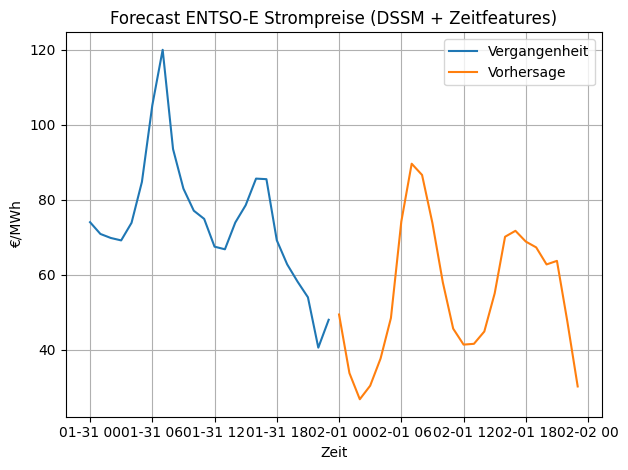

In [38]:
model.eval()
with torch.no_grad():
    x = torch.tensor(norm_series[-input_len:], dtype=torch.float32).unsqueeze(0)

    h_last = prices.index[-forecast_len:]
    h_sin = np.sin(2 * np.pi * h_last.hour / 24)
    h_cos = np.cos(2 * np.pi * h_last.hour / 24)
    f_exog = torch.tensor(np.stack([h_sin, h_cos], axis=-1), dtype=torch.float32).unsqueeze(0)

    pred = model(x, f_exog).numpy().flatten()
    pred_rescaled = pred * std + mean

plt.plot(prices.index[-input_len:], x.squeeze().numpy() * std + mean, label="Vergangenheit")
forecast_index = [prices.index[-1] + timedelta(hours=i+1) for i in range(forecast_len)]
plt.plot(forecast_index, pred_rescaled, label="Vorhersage")
plt.title("Forecast ENTSO-E Strompreise (DSSM + Zeitfeatures)")
plt.xlabel("Zeit")
plt.ylabel("€/MWh")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


9. month & weekplots

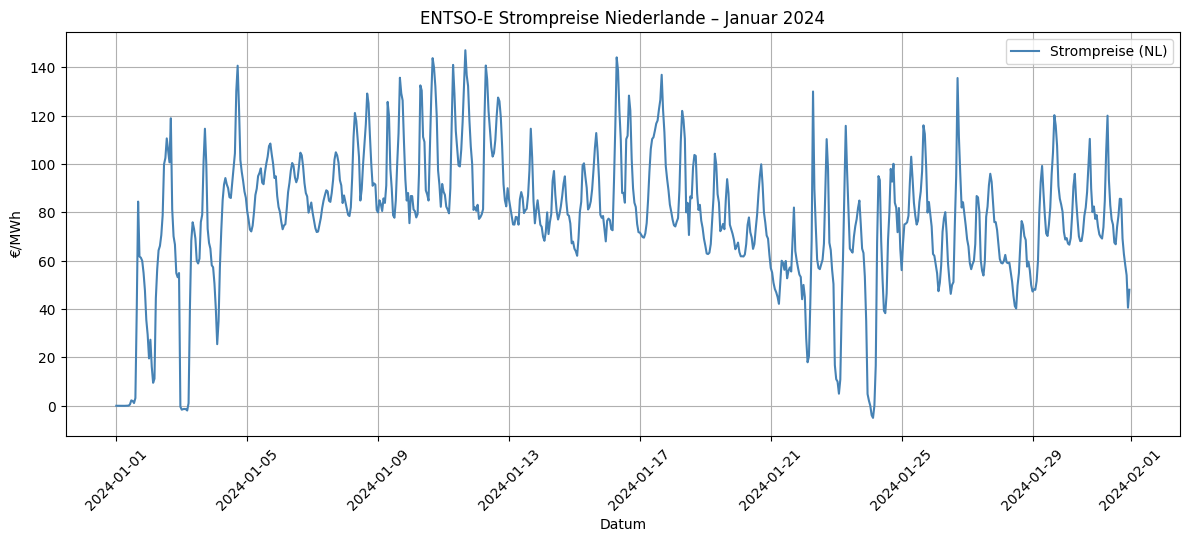

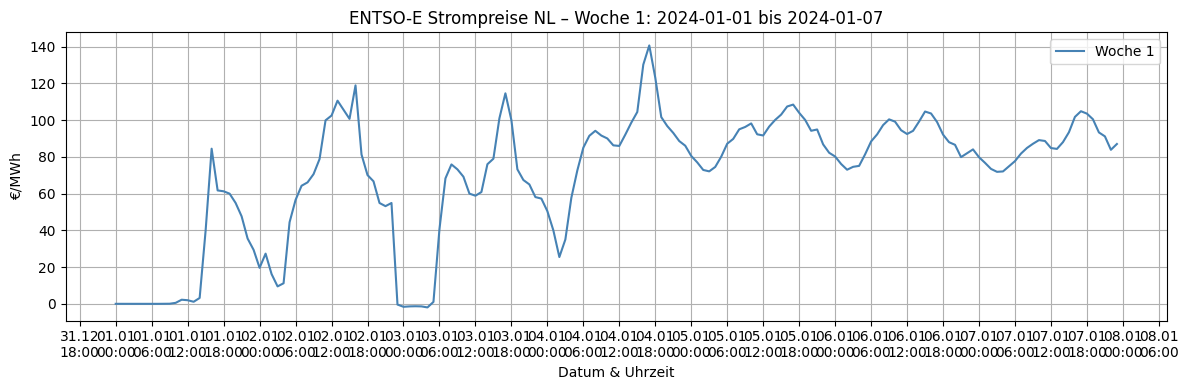

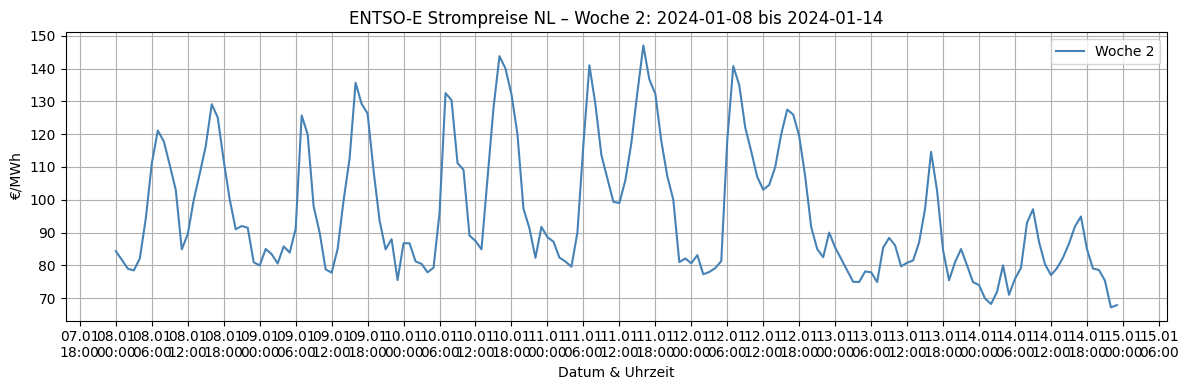

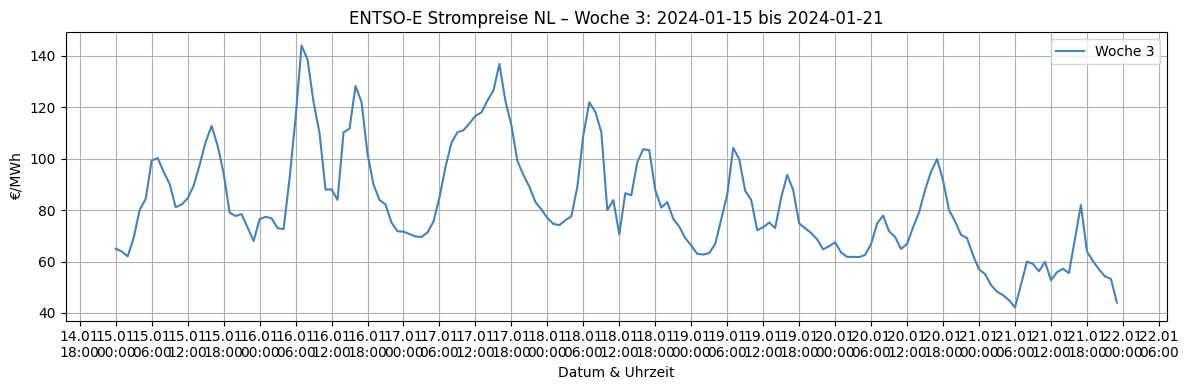

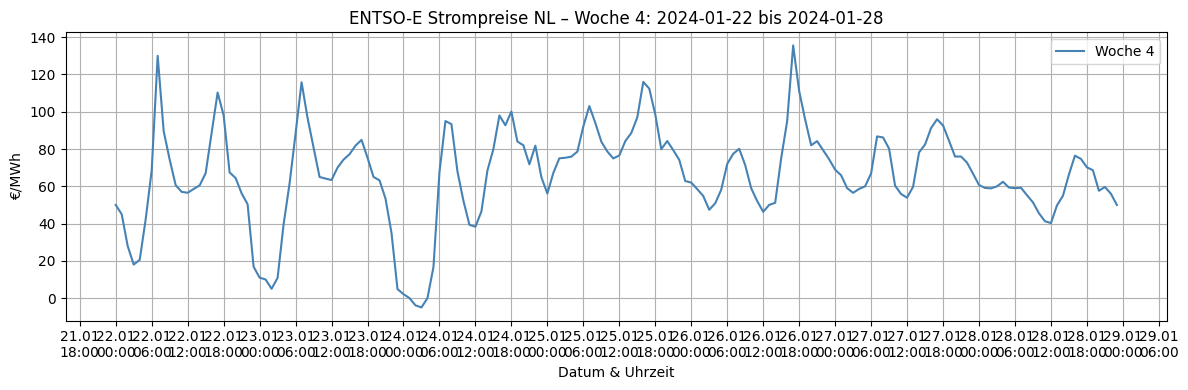

In [39]:
plt.figure(figsize=(12, 5))
plt.plot(prices.index, prices.values, label="Strompreise (NL)", color="steelblue")
plt.title("ENTSO-E Strompreise Niederlande – Januar 2024")
plt.xlabel("Datum")
plt.ylabel("€/MWh")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

import matplotlib.dates as mdates

weeks = [("2024-01-01", "2024-01-07"),
         ("2024-01-08", "2024-01-14"),
         ("2024-01-15", "2024-01-21"),
         ("2024-01-22", "2024-01-28")]

for i, (start, end) in enumerate(weeks, 1):
    week_data = prices[start:end]
    plt.figure(figsize=(12, 4))
    plt.plot(week_data.index, week_data.values, label=f"Woche {i}", color="steelblue")
    plt.title(f"ENTSO-E Strompreise NL – Woche {i}: {start} bis {end}")
    plt.xlabel("Datum & Uhrzeit")
    plt.ylabel("€/MWh")
    plt.grid(True)
    plt.legend()
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m\n%H:%M'))
    plt.tight_layout()
    plt.xticks(rotation=0)
    plt.show()
